Начнем с бинарной логистической регрессии:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [3]:
def logit(x, w):
    return np.dot(x, w)

In [4]:
class MyLogisticRegression:

  def __init__(self):
    self.w = None
  def fit(self, X, y, iterations=10000, lr=1e-2):
    n, k = X.shape        
    if self.w is None:
        np.random.seed(42)
        self.w = np.random.randn(k + 1)
    X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
    for i in range(iterations):
      y_pred = sigmoid(logit(X_train, self.w))
      self.w -= lr * self.get_grad(X_train, y, y_pred) 

  def get_grad(self, X, y, predictions):
     grad = -np.dot(X.T, y * (1 - predictions) - (1 - y) * predictions)
     return grad

  def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))
      
  def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold

  def get_weights(self):
    return self.w.copy() 
  


Тестируем:

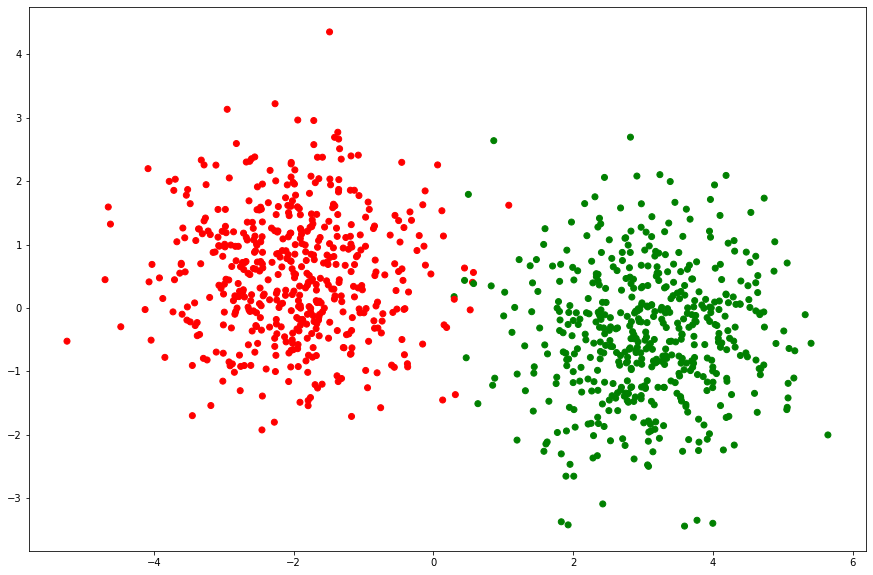

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [7]:
clf = MyLogisticRegression()
clf.fit(X_train, y_train)
w = clf.get_weights()

Посмотрим разделение тестовой выборки:

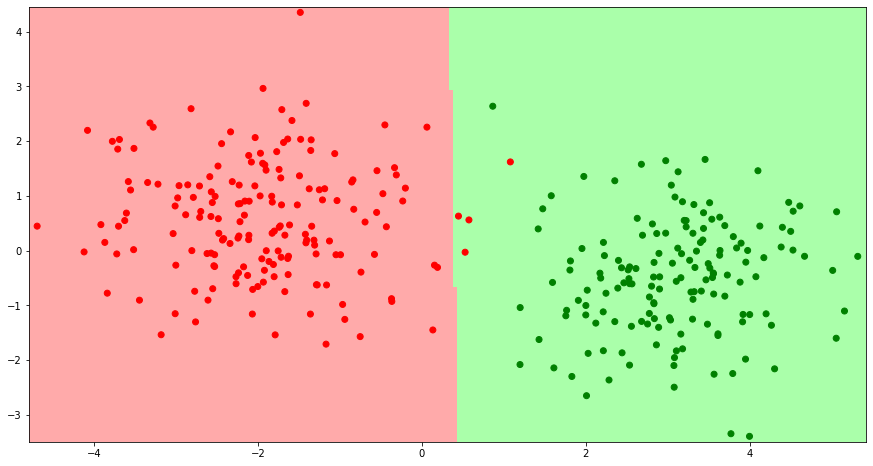

In [8]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X_test[:,0]) - eps, np.max(X_test[:,0]) + eps, 200),
                     np.linspace(np.min(X_test[:,1]) - eps, np.max(X_test[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
colored_y_test = np.zeros(y_test.size, dtype=str)
for i, cl in enumerate([0,1]):
    colored_y_test[y_test.ravel() == cl] = str(colors[i])
plt.scatter(X_test[:, 0], X_test[:, 1], c=colored_y_test)

Веса:

In [9]:
w


array([-4.08207494, 10.78860527,  0.15431371])

Сравним с реализацией из sklearn:

In [10]:
logisticRegr = LogisticRegression(penalty='none')

In [11]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(penalty='none')

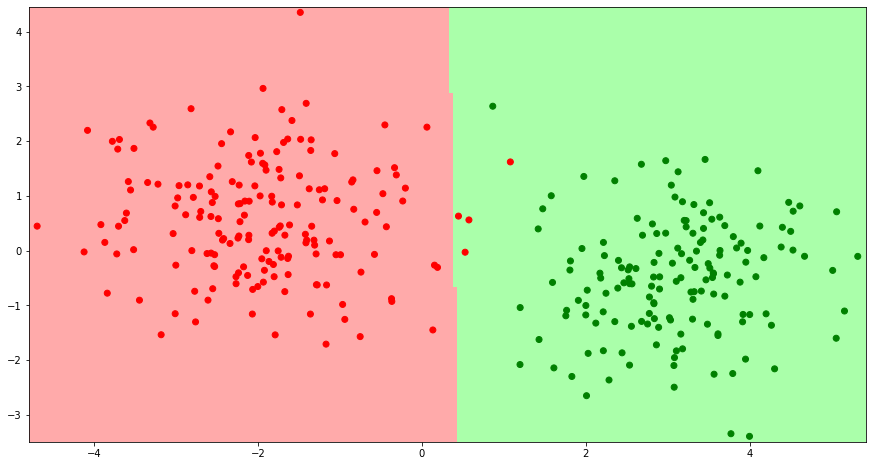

In [12]:
plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X_test[:,0]) - eps, np.max(X_test[:,0]) + eps, 200),
                     np.linspace(np.min(X_test[:,1]) - eps, np.max(X_test[:,1]) + eps, 200))
Z = logisticRegr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
colored_y_test = np.zeros(y_test.size, dtype=str)
for i, cl in enumerate([0,1]):
    colored_y_test[y_test.ravel() == cl] = str(colors[i])
plt.scatter(X_test[:, 0], X_test[:, 1], c=colored_y_test)

In [13]:
logisticRegr.coef_

array([[10.82180477,  0.15542657]])

In [14]:
logisticRegr.intercept_

array([-4.09532622])

Веса очень близки.

Сравним accuracy для обеих регрессий:

In [15]:
score_sklearn = logisticRegr.score(X_test, y_test)

In [16]:
score_sklearn

0.9878787878787879

In [17]:
score_my_logistic = np.array(clf.predict(X_test) == y_test).sum()/330

In [18]:
score_my_logistic

0.9878787878787879

Accuracy совпадает(что неудивительно для такой маленькой выборки)

Теперь перейдем к Ridge регрессии:

In [19]:
from sklearn.base import BaseEstimator, RegressorMixin

In [20]:
class LinRegRidge(BaseEstimator, RegressorMixin):
    
    def __init__(self, num_steps=350, lr=1e-2, lambd = 1):
        self.num_steps = num_steps
        self.lr = lr
        self.lambd = lambd
    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        for i in range(self.num_steps):
            w -= (2 * self.lr * np.dot(X.T, np.dot(X, w) - Y) / Y.size + (2 * self.lambd * w) / Y.size ) 

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

Сравним с моделью из коробки:

In [21]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

#Генерация данных для тестирования
n_features = 700
n_objects = 100000

w_true = np.random.uniform(-2, 2, (n_features, 1))

X = np.random.uniform(-100, 100, (n_objects, n_features)) * np.arange(n_features)
Y = X.dot(w_true) + np.random.normal(0, 10, (n_objects, 1))

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [23]:
scaler = StandardScaler()
scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [24]:
own_model = LinRegRidge().fit(x_scaled, y_train)
y_pred = own_model.predict(x_test_scaled)
own_r2 = r2_score(y_test, y_pred)

sklearn_model = Ridge(alpha=1).fit(x_scaled, y_train)
y_pred = sklearn_model.predict(x_test_scaled)

sklearn_r2 = r2_score(y_test, y_pred)

print('R^2 in own model:', own_r2)
print('R^2 in sklearn loss:', sklearn_r2)

R^2 in own model: 0.9999851604335356
R^2 in sklearn loss: 0.9999999996194726


Теперь посмотрим на то, как работает регуляризация на стохастическом спуске:

In [37]:
class LinRegStohRidge(BaseEstimator, RegressorMixin):
    
    def __init__(self, batch_size=25, num_steps=350, lr=1e-2, lambd=1):
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lr = lr
        self.lambd = lambd
    def fit(self, X, Y):
        w = np.random.randn(X.shape[1])[:, None]
        n_objects = len(X)

        for i in range(self.num_steps):
            sample_indices = np.random.randint(0, n_objects, size=self.batch_size)
            w -= (2 * self.lr * np.dot(X[sample_indices].T, np.dot(X[sample_indices], w) - Y[sample_indices]) / self.batch_size + (2 * self.lambd * w) / Y.size )

        self.w = w
        return self

    def predict(self, X):
        return X@self.w

In [38]:
own_model_stoh = LinRegStohRidge().fit(x_scaled, y_train)
y_pred = own_model_stoh.predict(x_test_scaled)
own_r2 = r2_score(y_test, y_pred)

sklearn_model = Ridge(alpha=1).fit(x_scaled, y_train)
y_pred = sklearn_model.predict(x_test_scaled)

sklearn_r2 = r2_score(y_test, y_pred)

print('R^2 in own model:', own_r2)
print('R^2 in sklearn loss:', sklearn_r2)

R^2 in own model: 0.9999286138565318
R^2 in sklearn loss: 0.9999999996194726
